In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
## 데이터 불러오기
trn = pd.read_csv('data/train.csv')
tst = pd.read_csv('data/test.csv')

In [3]:
## 365 변환
def days_to_plus(x):
    return (x*-1)/365

## 업무 시작일 변환
def plus(x):
    if x<0:
        return x*(-1)
    else:
        return 0

## 나이 양수로 변환
trn['birth_plus'] = trn.DAYS_BIRTH.map(days_to_plus)
tst['birth_plus'] = tst.DAYS_BIRTH.map(days_to_plus)
    
## 업무시작일 양수로 변환
trn['employed_plus'] = trn.DAYS_EMPLOYED.map(days_to_plus)
tst['employed_plus'] = tst.DAYS_EMPLOYED.map(days_to_plus)

In [4]:
index_col = 'index'
target_col = 'credit'

cat_cols = [x for x in trn.columns if trn[x].dtype == 'object']
float_cols = [x for x in trn.columns.drop('credit') if trn[x].dtype == 'float64']
num_cols = [x for x in trn.columns if x not in cat_cols + [target_col]]
feature_cols = num_cols + cat_cols
print(len(feature_cols), len(cat_cols), len(num_cols))

21 8 13


In [5]:
from sklearn.preprocessing import LabelEncoder

lbe = LabelEncoder()
for i in cat_cols:
    trn[i] = lbe.fit_transform(trn[i].astype(str))
    tst[i] = lbe.transform(tst[i].astype(str))
    
for i in float_cols:
    trn[i] = trn[i].astype('int')
    tst[i] = tst[i].astype('int')

In [6]:
## 인덱스 설정
trn.set_index('index', inplace = True)
tst.set_index('index', inplace = True)

In [8]:
trn.credit = trn.credit.astype('category')

In [9]:
trn6 = trn.drop(['family_size', 'employed_plus'], axis = 1).copy()

In [10]:
## 연봉 제곱 변수 제거
trn6['income_total_2'] = trn6.income_total**2
tst['income_total_2'] = tst.income_total**2

## DAYS_BIRTH 제곱 변수 추가
trn6['DAYS_BIRTH**2'] = trn6.DAYS_BIRTH**2
tst['DAYS_BIRTH**2'] = tst.DAYS_BIRTH**2

## income * days_birth
trn6['income_age']=trn6.income_total*trn6.DAYS_BIRTH
tst['income_age']=tst.income_total*tst.DAYS_BIRTH

## income * DAYS_EMPLOYED
trn6['income_emp']=trn6.income_total*trn6.DAYS_EMPLOYED
tst['income_emp']=tst.income_total*tst.DAYS_EMPLOYED

In [11]:
print(trn6.shape)

(26457, 23)


In [12]:
trn6.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'begin_month', 'credit', 'birth_plus', 'income_total_2',
       'DAYS_BIRTH**2', 'income_age', 'income_emp'],
      dtype='object')

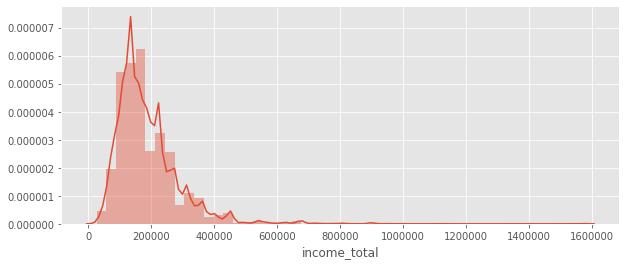

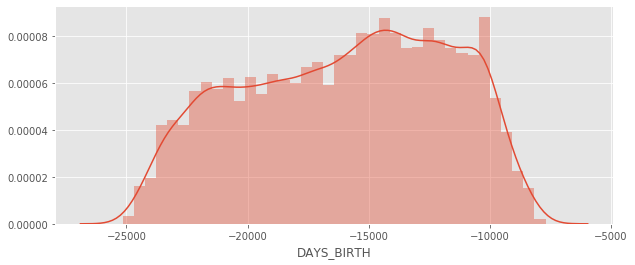

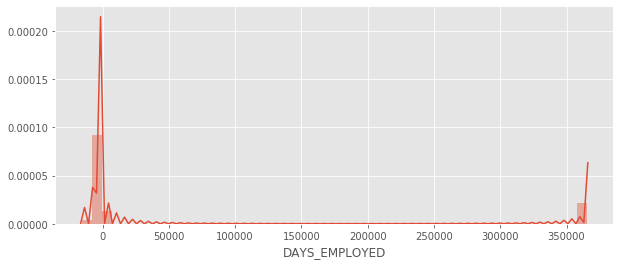

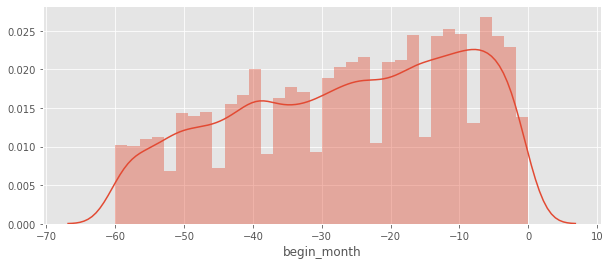

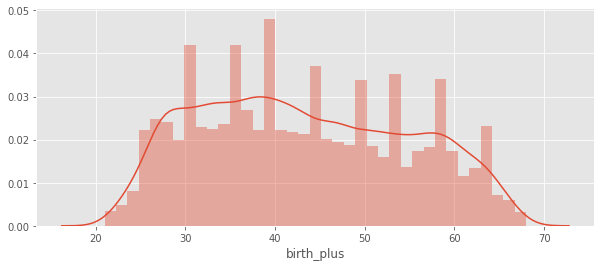

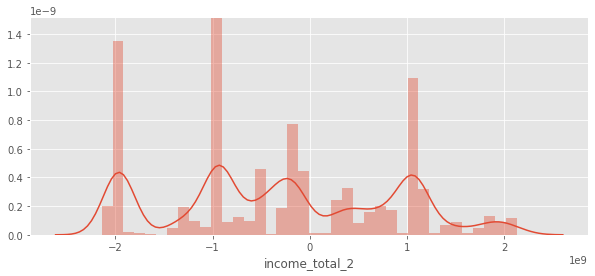

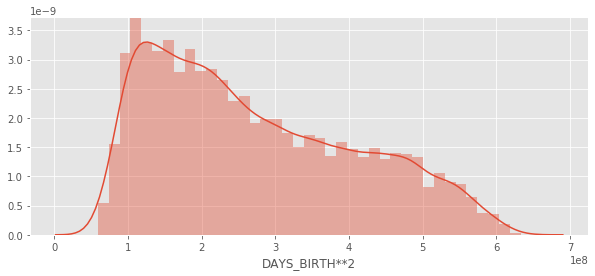

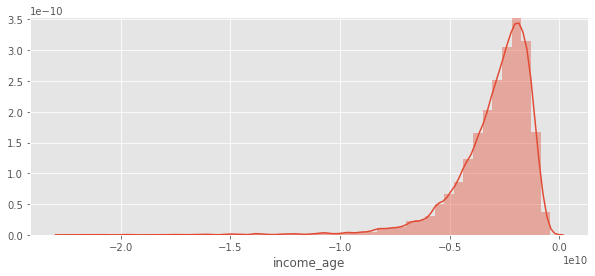

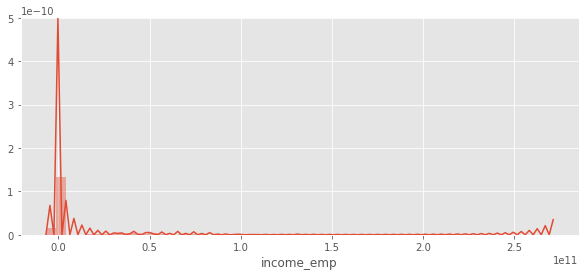

In [244]:
for i in ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'birth_plus', 'income_total_2','DAYS_BIRTH**2', 'income_age', 'income_emp']:
    plt.figure(figsize=(10,4))
    sns.distplot(trn6[i], label = i)
    plt.show()

##  연속형으로 표현되어 있는 변수들만 로그 변환 및 지수변환 수행

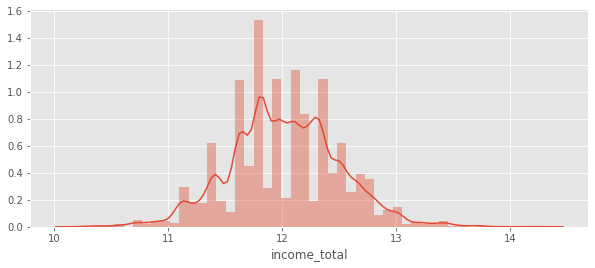

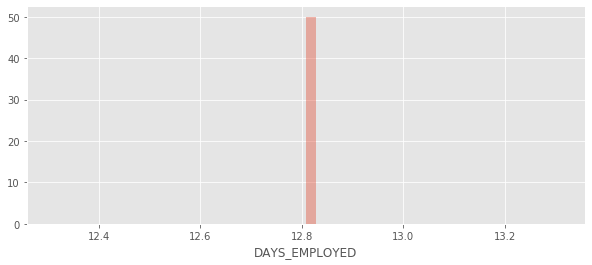

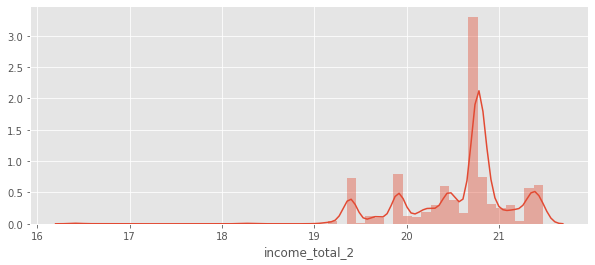

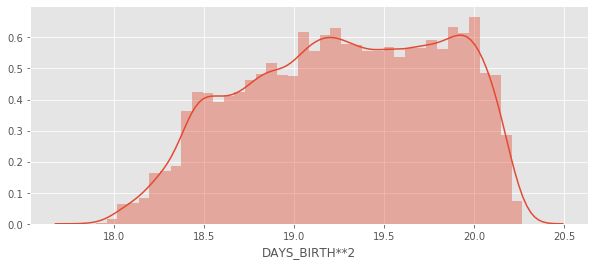

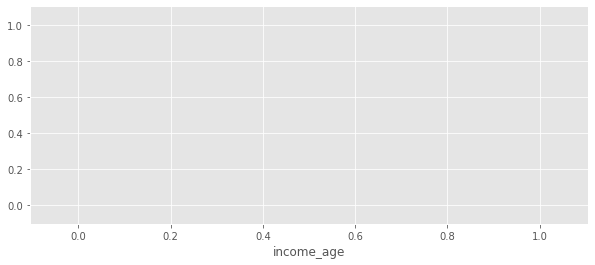

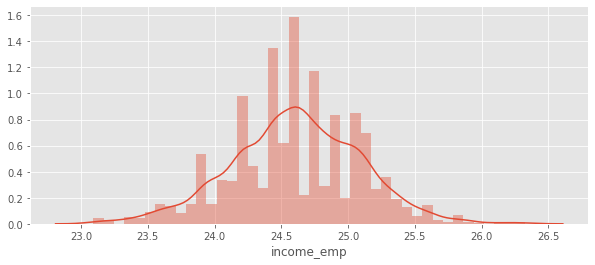

In [21]:
for i in ['income_total', 'DAYS_EMPLOYED', 'income_total_2','DAYS_BIRTH**2', 'income_age', 'income_emp']:
    plt.figure(figsize=(10,4))
    sns.distplot(np.log1p(trn6[i]+(1e-14)), label = i)
    plt.show()

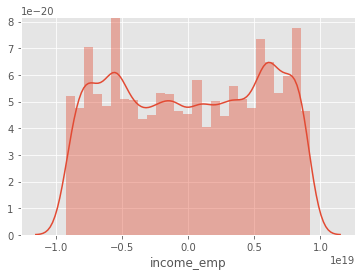

In [35]:
sns.distplot(trn6.income_emp**5, label = i)

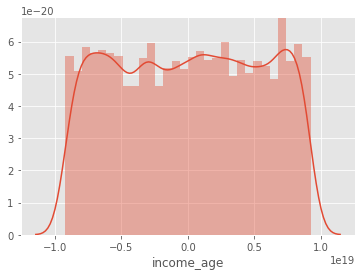

In [246]:
sns.distplot(trn6.income_age**(3), label = i)

- income_age는 3제곱
- income_emp는 2제곱
- 나머지는 모두 로그변환

In [10]:
trn6.columns

Index(['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'occyp_type',
       'begin_month', 'credit', 'birth_plus', 'income_total_2',
       'DAYS_BIRTH**2', 'income_age', 'income_emp'],
      dtype='object')

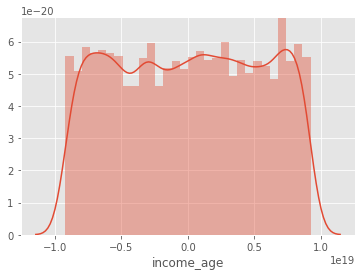

In [23]:
sns.distplot(trn6.income_age**3)

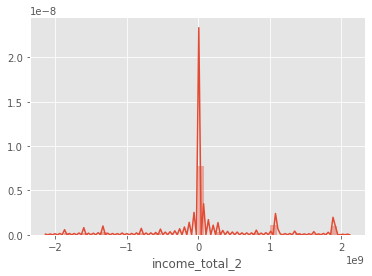

In [198]:
sns.distplot(trn6.income_total_2**(6), label = i)

In [247]:
for i in ['income_total','DAYS_BIRTH**2']:
    trn6[i] = np.log1p(trn6[i])
trn6.income_total_2 = trn6.income_total_2**6
trn6.income_emp = trn6.income_emp**2
trn6.income_age = trn6.income_age**3

for i in ['income_total','DAYS_BIRTH**2']:
    tst[i] = np.log1p(tst[i])

tst.income_total_2 = tst.income_total_2**6
tst.income_emp = tst.income_emp**2
tst.income_age = tst.income_age**3

In [215]:
for i in ['income_total','DAYS_BIRTH**2']:
    trn6[i] = np.log1p(trn6[i])
trn6.income_total_2 = trn6.income_total_2**6
trn6.income_emp = trn6.income_emp**2
trn6.income_age = trn6.income_age**13

for i in ['income_total','DAYS_BIRTH**2']:
    tst[i] = np.log1p(tst[i])

tst.income_total_2 = tst.income_total_2**6
tst.income_emp = tst.income_emp**2
tst.income_age = tst.income_age**13

In [262]:
## 조합 1차시도
for i in ['income_total','DAYS_BIRTH**2']:
    trn6[i] = np.log1p(trn6[i])
trn6.income_total_2 = trn6.income_total_2**6
trn6.income_emp = trn6.income_emp**2
# trn6.income_age = trn6.income_age**3

for i in ['income_total','DAYS_BIRTH**2']:
    tst[i] = np.log1p(tst[i])

tst.income_total_2 = tst.income_total_2**6
tst.income_emp = tst.income_emp**2
# tst.income_age = tst.income_age**3

In [273]:
## 조합 2차시도
for i in ['income_total','DAYS_BIRTH**2']:
    trn6[i] = np.log1p(trn6[i])
trn6.income_total_2 = trn6.income_total_2**6
# trn6.income_emp = trn6.income_emp**2
trn6.income_age = trn6.income_age**3

for i in ['income_total','DAYS_BIRTH**2']:
    tst[i] = np.log1p(tst[i])

tst.income_total_2 = tst.income_total_2**6
# tst.income_emp = tst.income_emp**2
tst.income_age = tst.income_age**3

In [13]:
## trn6.income_emp : 직사각형 형태 찾기
    # income_emp**5 가 가장 대칭에 가까운 직사각형의 형태를 띔
    
for i in ['income_total','DAYS_BIRTH**2']:
    trn6[i] = np.log1p(trn6[i])
# 3으로 해보기
trn6.income_total_2 = trn6.income_total_2**6
trn6.income_emp = trn6.income_emp**5
trn6.income_age = trn6.income_age**3

for i in ['income_total','DAYS_BIRTH**2']:
    tst[i] = np.log1p(tst[i])

tst.income_total_2 = tst.income_total_2**6
tst.income_emp = tst.income_emp**5
tst.income_age = tst.income_age**3

In [37]:
trn6.isnull().sum()

gender            0
car               0
reality           0
child_num         0
income_total      0
income_type       0
edu_type          0
family_type       0
house_type        0
DAYS_BIRTH        0
DAYS_EMPLOYED     0
FLAG_MOBIL        0
work_phone        0
phone             0
email             0
occyp_type        0
begin_month       0
credit            0
birth_plus        0
income_total_2    0
DAYS_BIRTH**2     0
income_age        0
income_emp        0
dtype: int64

In [38]:
tst.isnull().sum()

gender            0
car               0
reality           0
child_num         0
income_total      0
income_type       0
edu_type          0
family_type       0
house_type        0
DAYS_BIRTH        0
DAYS_EMPLOYED     0
FLAG_MOBIL        0
work_phone        0
phone             0
email             0
occyp_type        0
family_size       0
begin_month       0
birth_plus        0
employed_plus     0
income_total_2    0
DAYS_BIRTH**2     0
income_age        0
income_emp        0
dtype: int64

In [39]:
trn6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   gender          26457 non-null  int32   
 1   car             26457 non-null  int32   
 2   reality         26457 non-null  int32   
 3   child_num       26457 non-null  int64   
 4   income_total    26457 non-null  float64 
 5   income_type     26457 non-null  int32   
 6   edu_type        26457 non-null  int32   
 7   family_type     26457 non-null  int32   
 8   house_type      26457 non-null  int32   
 9   DAYS_BIRTH      26457 non-null  int64   
 10  DAYS_EMPLOYED   26457 non-null  int64   
 11  FLAG_MOBIL      26457 non-null  int64   
 12  work_phone      26457 non-null  int64   
 13  phone           26457 non-null  int64   
 14  email           26457 non-null  int64   
 15  occyp_type      26457 non-null  int32   
 16  begin_month     26457 non-null  int32   
 17  credit      

In [14]:
trn6.income_total = trn6.income_total.astype(int)
trn6['DAYS_BIRTH**2'] = trn6['DAYS_BIRTH**2'].astype(int)

tst.income_total = tst.income_total.astype(int)
tst['DAYS_BIRTH**2'] = tst['DAYS_BIRTH**2'].astype(int)

In [ ]:
### 이 기록은 라벨인코딩을 따로 지정하지 않고 한번에 돌린 데이터
### trn6은 trn6 = trn.drop(['family_size', 'employed_plus'], axis = 1).copy()이다.
### 총 18개의 변수를 사용한 것 -> 최고기록

## predict_rf
ftr = trn6.drop('credit', axis=1).values
target = trn['credit'].values
tst_ar = tst.drop(['family_size', 'employed_plus'], axis = 1).values
n_class = 3
n_fold = 10

print(ftr.shape)
print(tst_ar.shape)


cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=40)

rf_p_val = np.zeros((ftr.shape[0], n_class))
rf_p_tst = np.zeros((tst_ar.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr, target), 1):
    print(f'training model for CV #{i}')
    rf_clf = RandomForestClassifier(n_estimators = 7000, 
                                random_state=2021,
                                max_features = 3,
                                min_samples_split = 8,
                                n_jobs=2)
    rf_clf.fit(ftr[i_trn], target[i_trn])
    rf_p_val[i_val, :] = rf_clf.predict_proba(ftr[i_val])
    rf_p_tst += rf_clf.predict_proba(tst_ar) / n_fold
    
print(f'{log_loss(target, rf_p_val)}')
print(f'{confusion_matrix(target, np.argmax(rf_p_val, axis=1))}%')

(26457, 22)
(10000, 22)
training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4


In [163]:
sub = pd.read_csv('data/sample_submission.csv', index_col = 0)
sub
sub[sub.columns] = rf_p_tst

In [164]:
sub.to_csv('data/데이터_재표현(전부).csv')

1. trn6.income_age**(3) 으로 했을 때가 0.6866962841415036
2. trn6.income_age**13 으로 했을 때가 0.6873255407581582
*정규분포 형태와 아닌 형태로 대칭인 것만 같고 조금 다름*
=> 직사각형이 더 좋음
3. trn6.income_age 변환 안 함 : 0.6884951810307259
4. tst.income_emp 변환 안 함 :0.6874159266024837
5. tst.income_emp 5제곱으로 직사각형으로 만듦 : 0.6865284163441506